# Feature selection on detector regions
We consider detector regions to be all combinations of volumes with their associated layers. When we look at the detector layout, any horizontal or vertical bar is considered to be a detector region.

<img src="images/Detector.png" alt="Detector layout" width="600"/>

In [27]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from scripts.tracks import get_tracks
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

#### Unpickle FE dataframe and FS feature importances

In [44]:
event_id = 'event000001000'
data = pd.read_pickle('/home/alepfu/Desktop/dataset/pickle/' + event_id + '_FE.pkl')
print(data.shape)

feature_importances = pd.read_pickle('/home/alepfu/Desktop/dataset/pickle/feature_importances.pkl')
print(feature_importances.shape)

(120939, 46)
(38, 5)


#### Pick a sample of tracks

In [29]:
N_tracks = 0
data = get_tracks(data, N_tracks=N_tracks, drop_zero_weights=False, drop_zero_id=False, factorize_particle_id=False)
data.shape

(120939, 46)

#### Pick a subset of features
For now we only keep high ranking features (high mean importance), see FS notebook.

In [30]:
N_features = 13
features = feature_importances.head(N_features)['feature'].values
features

array(['x_r_sph', 'y_r_sph', 'cos_dist_rc', 'phi', 'cos_dist_lc',
       'z_r_cyl', 'z_r_sph', 'theta', 'phi_atan2', 'y_r_cyl',
       'theta_atan2', 'x_r_cyl', 'theta_pixel'], dtype=object)

In [31]:
data = data[np.insert(features, 0, ['hit_id','particle_id','vol_lay_concat'], axis=0)].copy()
data.shape

(120939, 16)

#### Set detector regions

In [32]:
regions = np.array([72,74,76,78,710,712,714])

#
#,82,84,86,88,92,94,96,98,910,912,914,
#                    122,124,126,128,1210,1212,132,134,136,138,142,144,146,148,1410,1412,
#                    162,164,166,168,1610,1612,172,174,182,184,186,188,1810,1812

print('Number of detector regions:', len(regions))


Number of detector regions: 7


### Atm we keep it simple and only use decsion tree for feature importances, later we add other trees.

In [33]:
%%time

mm_scaler = MinMaxScaler(feature_range=(0,100))

imps = []
nhits = []
scores = []
roc_auc = []

for reg in regions:
    data_reg = data[data['vol_lay_concat'] == reg]
    nhits.append(data_reg.shape[0])
    
    X = data_reg.iloc[:,3:]
    y = data_reg[['particle_id']].values.ravel()
    y = label_binarize(y, classes=list(np.unique(y)))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    dec_tree = DecisionTreeClassifier(random_state=0)
    dec_tree.fit(X_train, y_train)   
    dec_tree_preds = dec_tree.predict(X_test)
    roc_auc.append(roc_auc_score(y_test, dec_tree_preds, average='micro'))
    scores.append(dec_tree.score(X_test, y_test))
    
    imps_scaled = mm_scaler.fit_transform(dec_tree.feature_importances_.reshape(-1,1))
    imps_scaled = imps_scaled.reshape(1,-1).ravel()
    imps.append(imps_scaled) 

CPU times: user 1min 53s, sys: 268 ms, total: 1min 54s
Wall time: 1min 54s


In [34]:
dec_tree_df = pd.concat([pd.DataFrame(regions, columns=['region']), 
                         pd.DataFrame(np.array(imps), columns=features), 
                         pd.DataFrame(nhits, columns=['nhits']), 
                         pd.DataFrame(scores, columns=['score']),
                         pd.DataFrame(roc_auc, columns=['roc_auc'])], axis=1)

dec_tree_df.head(len(regions))

,region,x_r_sph,y_r_sph,cos_dist_rc,phi,cos_dist_lc,z_r_cyl,z_r_sph,theta,phi_atan2,y_r_cyl,theta_atan2,x_r_cyl,theta_pixel,nhits,score,roc_auc
0,72,73.177397,73.383202,11.788410,8.213213,0.000000,27.851802,38.188315,100.000000,31.230720,68.430182,58.206453,72.147596,20.979176,1449,0.379310,0.689338
1,74,100.000000,76.927999,14.745343,4.902731,0.000000,39.473624,11.627311,82.444196,45.781014,48.163314,68.726710,77.375568,33.263509,1767,0.511299,0.755436
2,76,94.724051,80.687008,0.000000,18.279984,19.689286,22.275643,10.767096,100.000000,30.740733,46.374739,68.311839,38.152133,27.997853,2165,0.487298,0.743455
3,78,76.150639,80.510404,15.133191,7.018348,19.729615,24.121597,0.000000,100.000000,17.982871,63.967178,89.339147,49.650137,12.861490,2553,0.547945,0.773819
4,710,97.033072,96.528735,18.463109,0.000000,0.351617,20.706081,24.091733,100.000000,2.268555,65.879075,88.579494,87.605492,16.089446,2887,0.605536,0.802647
5,712,100.000000,78.223048,4.791410,21.476829,0.000000,3.024627,2.319841,60.774871,3.692889,37.480382,88.569992,63.320367,2.312751,3028,0.594059,0.796908
6,714,78.298026,57.893572,10.588295,27.085934,9.860668,9.052721,0.000000,72.182646,7.551399,35.962661,100.000000,68.908976,8.694888,3024,0.631405,0.815594


### Viz feature importances for every detector region

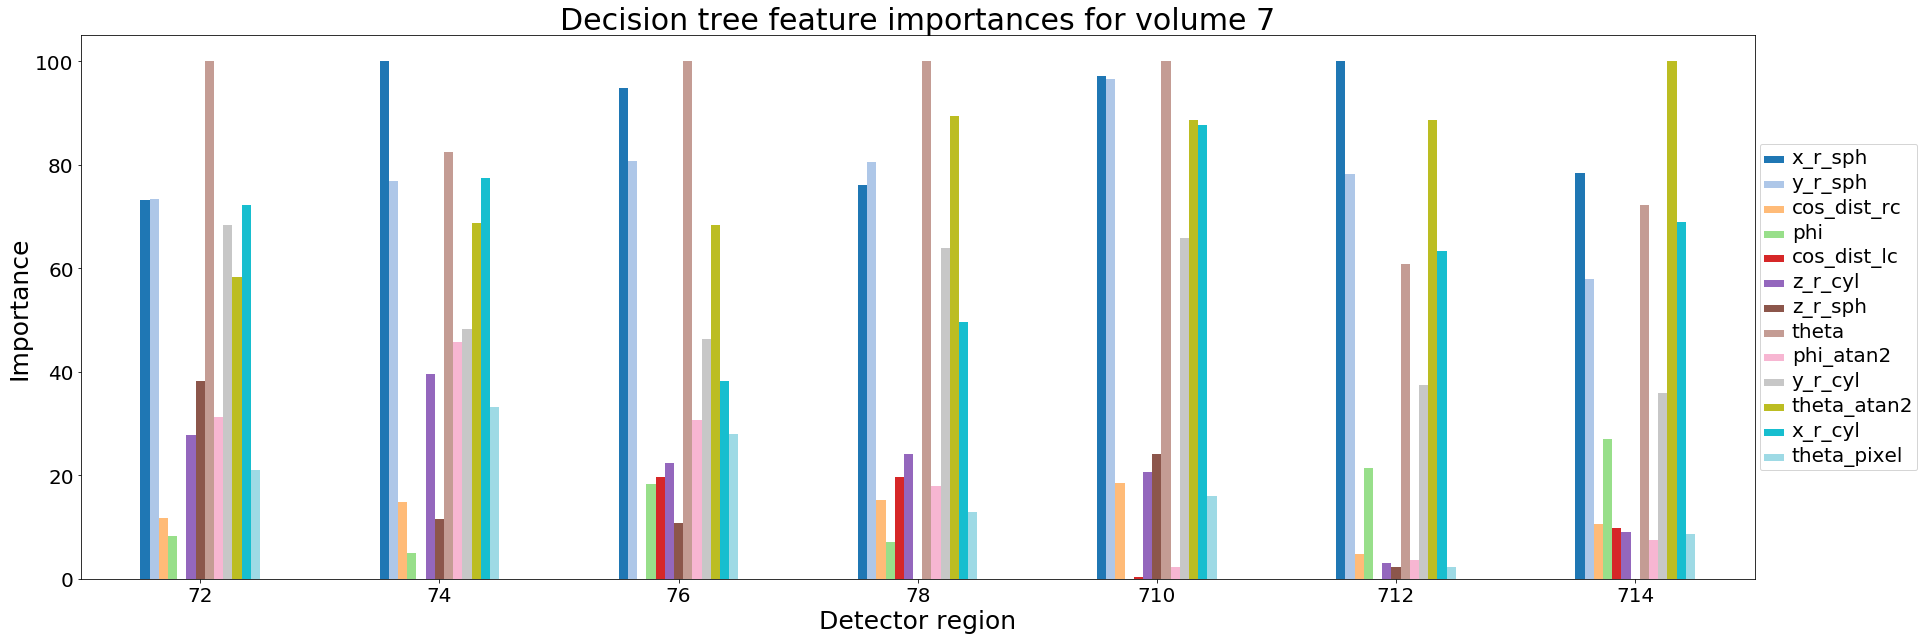

In [35]:
ax = dec_tree_df[np.insert(features, 0, ['region'], axis=0)].plot(x='region', kind='bar', figsize=(30,10), colormap='tab20')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_xlabel('Detector region', fontsize=25);
ax.set_ylabel('Importance',fontsize=25);
ax.set_title('Decision tree feature importances for volume 7', fontsize=30);
ax.tick_params(labelsize=20);
plt.setp(ax.get_legend().get_texts(), fontsize='20');

### Isolate features that change a lot from layer to layer

In [36]:
dec_tree_df.iloc[:,1:-3].var(axis=0)

x_r_sph        144.569891
y_r_sph        130.521921
cos_dist_rc     41.138213
phi             98.182608
cos_dist_lc     87.064764
z_r_cyl        144.249444
z_r_sph        202.353578
theta          266.368693
phi_atan2      274.239138
y_r_cyl        186.574032
theta_atan2    228.750276
x_r_cyl        281.518650
theta_pixel    117.078805
dtype: float64

In [42]:


var_df

,0,1
x_r_sph,144.569891,144.569891
y_r_sph,130.521921,130.521921
cos_dist_rc,41.138213,41.138213
phi,98.182608,98.182608
cos_dist_lc,87.064764,87.064764
z_r_cyl,144.249444,144.249444
z_r_sph,202.353578,202.353578
theta,266.368693,266.368693
phi_atan2,274.239138,274.239138
y_r_cyl,186.574032,186.574032
